In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import copy


# Lecture des données

In [ ]:
df = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")

In [ ]:
df.head().T

# Interprétation des paramètres

- Pregnancies -> Nombre de grossesses
- Glucose -> Glucose dans le sang
- BloodPressure -> Pression Sanguine
- SkinThickness -> Épaisseur de la peau
- Insulin -> Insuline dans le sang
- BMI -> Indice de Masse Corporelle (IMC)
- DiabetesPedigreeFunction -> 
- Age -> Age
- Outcome -> Résultat (0 = Negative; 1 = Positive)

# Grossesse et diabetes: relation et probabilité

In [ ]:
df.count()

In [ ]:
preg = (df.Pregnancies != 0.000)
preg.value_counts()

In [ ]:
df[preg].head(10)

In [ ]:
df[preg].Outcome.value_counts()

In [ ]:
pos = (df.Outcome == 1)
neg = (df.Outcome == 0)
preg_pos = preg & pos
preg_neg = preg & neg

In [ ]:
prob_pos = df[preg_pos].Pregnancies.count()/df[preg].Pregnancies.count()
print(prob_pos)

In [ ]:
prob_neg = df[preg_neg].Pregnancies.count()/df[preg].Pregnancies.count()
print(prob_neg)

# Conditionnement des données

Afin d'effectuer une analyse correcte des données, nous devons nous assurer que toutes les données sont correctes (ou du moins, adéquates).
En analysant la liste, nous avons vu qu'il y a des colonnes avec des données de valeur nulle qui ne correspondent pas à des données réelles. C'est pourquoi nous avons converti ces zéros en NaN et introduit une approximation à la place.

In [ ]:
not_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df = copy.deepcopy(df)

df[not_zero] = df[not_zero].replace(0, np.NaN)



In [ ]:
df.isnull().sum()

In [ ]:
df['Glucose'].fillna(df.Glucose.mean(), inplace=True)
df['BloodPressure'].fillna(df.BloodPressure.mean(), inplace=True)
df['BMI'].fillna(df.BMI.mean(), inplace=True)
df['SkinThickness'].fillna(df.SkinThickness.mean(), inplace=True)

df['Insulin'].fillna(df.Insulin.median(), inplace=True)

# Création des jeux d'apprentissage et de test


On sépare le dataset en deux parties :
- un ensemble d'apprentissage (80% des données), qui va permettre d'entraîner le modèle
- un ensemble de test (20% des données), qui va permettre d'estimer la pertinence de la prédiction


In [ ]:
X = df.drop(['Outcome'], axis=1)
y = df.Outcome

from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

# Regresion logistique
## Mesures de performance
En comparant les valeurs prédites et les valeurs réelles, on a plusieurs possibilités :

- Vrais positifs (VP ou TP) : on prédit "oui" et la valeur attendue est "oui"
- Vrais négatifs (VN ou TN) : on prédit "non" et la valeur attendue est "non"
- Faux positifs (FP) : on prédit "oui" et la valeur attendue est "non"
- Faux négatifs (FN) : on prédit "non" et la valeur attendue est "oui"

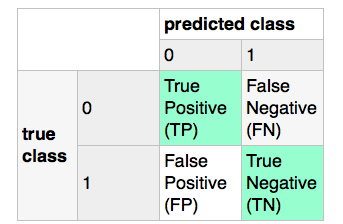

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

In [ ]:
y_lr = lr.predict(X_test)

print("Confusion matrix:\n", confusion_matrix(y_test,y_lr))



In [ ]:
print("Accuracy =", accuracy_score(y_test,y_lr))

In [ ]:
print(classification_report(y_test, y_lr))

In [ ]:
probas = lr.predict_proba(X_test)
print(probas)

In [ ]:
dfprob = pd.DataFrame(probas,columns=['proba_0','proba_1'])
dfprob['y'] = np.array(y_test)

dfprob

### On affiche la distribution des probabilités de prédiction de 1, et celle des non probabilités de prédiction de 0 :

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(1-dfprob.proba_0[dfprob.y==0], bins=50)
sns.distplot(dfprob.proba_1[dfprob.y==1], bins=50)

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,probas[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

In [ ]:
plt.figure(figsize=(12,12))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')    
plt.plot([0,0,1],[0,1,1],'g:') 
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Random forests

In [ ]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

print(classification_report(y_test, y_rf))

In [ ]:
cm = confusion_matrix(y_test, y_rf)
print("Confusion matrix:\n", cm)

In [ ]:
rf1 = ensemble.RandomForestClassifier(n_estimators=10, min_samples_leaf=10, max_features=3)
rf1.fit(X_train, y_train)
y_rf1 = rf.predict(X_test)
print(classification_report(y_test, y_rf1))

In [ ]:
from sklearn.model_selection import validation_curve
params = np.arange(1, 300,step=30)
train_score, val_score = validation_curve(rf, X, y, 'n_estimators', params, cv=7)
plt.figure(figsize=(12,12))
plt.plot(params, np.median(train_score, 1), color='blue', label='training score')
plt.plot(params, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('n_estimators')
plt.ylabel('score');

# Améliorer la pertinence

La méthode GridSearchCV permet de tester plusieurs combinaisons de paramètres (listés dans une grille de paramètres) et de sélectionner celle qui donne la meilleure pertinence

In [ ]:
from sklearn import model_selection

param_grid = {
              'n_estimators': [10, 100, 500],
              'min_samples_leaf': [1, 20, 50]
             }
estimator = ensemble.RandomForestClassifier()
rf_gs = model_selection.GridSearchCV(estimator, param_grid)

In [ ]:
rf_gs.fit(X_train, y_train)

In [ ]:
print(rf_gs.best_params_)

In [ ]:
rf2 = rf_gs.best_estimator_
y_rf2 = rf2.predict(X_test)

print(classification_report(y_test, y_rf2))

# Importance des caractéristiques

In [ ]:
importances = rf2.feature_importances_
indices = np.argsort(importances)


In [ ]:
plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.title('Importance des caracteristiques')